In [3]:
from pyoculus.problems import CylindricalBfield
from pyoculus.solvers import PoincarePlot
import matplotlib.pyplot as plt
import numpy as np
from numba import jit

from $$\vec{B} = $$

In [139]:
import functools

def arraytize(f):
    @functools.wraps(f)
    def wrapper(x):
        return np.array([f(xi) for xi in x])

    return wrapper

In [236]:
@jit(nopython=True)
def toroidal(rr, R, sf, shear):
    return np.array(
        [
            (-2 * rr[2]) / rr[0],
            (
                2
                * np.sqrt(R**2 - (R - rr[0]) ** 2 - rr[2] ** 2)
                * (sf + shear * ((R - rr[0]) ** 2 + rr[2] ** 2))
            )
            / rr[0],
            (-2 * (R - rr[0])) / rr[0],
        ]
    )


@jit(nopython=True)
def mb_perturabation(rr, R, d, m, n):
    B_perturbed = np.array(
        [
            (
                rr[2]
                * np.sqrt((rr[0] - R) ** 2 + rr[2] ** 2)
                * (-2 * d**2 + (rr[0] - R) ** 2 + rr[2] ** 2)
                * np.cos(n * rr[1] + m * np.angle(rr[0] - R + rr[2] * 1j))
                + d**2
                * m
                * ((rr[0] - R) ** 2 + rr[2] ** 2)
                * np.sin(n * rr[1] + (-1 + m) * np.angle(rr[0] - R + rr[2] * 1j))
            ),
            0.0,
            (
                d**2
                * m
                * ((rr[0] - R) ** 2 + rr[2] ** 2)
                * np.cos(n * rr[1] + (-1 + m) * np.angle(rr[0] - R + rr[2] * 1j))
                - (rr[0] - R)
                * np.sqrt((rr[0] - R) ** 2 + rr[2] ** 2)
                * (-2 * d**2 + (rr[0] - R) ** 2 + rr[2] ** 2)
                * np.cos(n * rr[1] + m * np.angle(rr[0] - R + rr[2] * 1j))
            ),
        ]
    )

    return (
        np.sqrt(2 / np.pi)
        * ((rr[0] - R) ** 2 + rr[2] ** 2) ** ((-1 + m) / 2.0)
        * B_perturbed
        / (d**4 * np.exp(((rr[0] - R) ** 2 + rr[2] ** 2) / (2.0 * d**2)) * rr[0])
    )


@jit(nopython=True)
def gaussian_perturbation(rr, R, d, m, n):
    B_perturbed = np.array(
        [
            (
                rr[2]
                * np.sqrt((-R + rr[0]) ** 2 + rr[2] ** 2)
                * np.cos(n * rr[1] + m * np.angle(-R + rr[0] + rr[2] * 1j))
                + d**2
                * m
                * np.sin(n * rr[1] + (-1 + m) * np.angle(-R + rr[0] + rr[2] * 1j))
            ),
            0.0,
            (
                d**2
                * m
                * np.cos(n * rr[1] + (-1 + m) * np.angle(-R + rr[0] + rr[2] * 1j))
                + (-rr[0] + R)
                * np.sqrt((-R + rr[0]) ** 2 + rr[2] ** 2)
                * np.cos(n * rr[1] + m * np.angle(-R + rr[0] + rr[2] * 1j))
            ),
        ]
    )

    return (
        ((-R + rr[0]) ** 2 + rr[2] ** 2) ** ((-1 + m) / 2.0)
        * B_perturbed
        / (
            d**3
            * np.exp(((rr[0] - R) ** 2 + rr[2] ** 2) / (2.0 * d**2))
            * np.sqrt(2*np.pi)
            * rr[0]
        )
    )



In [ ]:
@jit(nopython=True)
def toroidal_dBdX(rr, R, sf, shear):
  term1 = 2 * rr[2] / rr[0]**2
  term2_sqrt = np.sqrt(-rr[0]**2 + 2 * rr[0] * R - rr[2]**2)
  term2_numerator = -2 * term2_sqrt * (sf + shear * (rr[0]**2 - 2 * rr[0] * R + R**2 + rr[2]**2))
  term2 = -term2_numerator / rr[0]**2
  term3 = -2 / rr[0]

  term4_numerator = -2 * (2 * rr[0]**4 * shear - 5 * rr[0]**3 * R * shear + rr[0]**2 * shear * (2 * R**2 + rr[2]**2) +
                            rr[0] * R * (sf + shear * (R**2 + rr[2]**2)) - rr[2]**2 * (sf + shear * (R**2 + rr[2]**2)))
  term4_denominator = rr[0]**2 * term2_sqrt
  term4 = term4_numerator / term4_denominator

  term5 = - term1
  term6_numerator = -2 * rr[2] * (sf + shear * (3 * rr[0]**2 - 6 * rr[0] * R + R**2 + 3 * rr[2]**2))
  term6_denominator = rr[0] * term2_sqrt
  term6 = term6_numerator / term6_denominator

  term7 = 2 * R / rr[0]**2

  return np.array([[term1, term2, term3],
                   [term4, term5, term6],
                   [term7, 0., 0.]])

In [27]:
def gaussian_psi(rr, R=3.0, d=0.1, m=2, n=1):
    return ((rr[0] - R + rr[2]*1j)**m)*np.exp(-0.5*((-rr[0] + R)**2 + rr[2]**2)/d**2 + 1j*n*0)/(np.sqrt(d**2)*np.sqrt(2*np.pi))

def mb_psi(rr, R=3.0, d=0.1, m=2, n=1):
    return np.exp(-0.5*((-rr[0] + R)**2 + rr[2]**2)/d**2 + n*rr[1]*1j)*np.sqrt(2/np.pi)*(rr[0] - R + rr[2]*1j)**m*((-rr[0] + R)**2 + rr[2]**2)/d**2

In [280]:
class CylindricalAnalyticBfield(CylindricalBfield):
    def __init__(self, **kwargs):
        defaults = {
            "R_0": 3.0,
            "shear": 1.0,
            "sf": 0.91,
            "A_p": 1.0,
            "d": 0.2,
            "m": 2,
            "n": 3,
        }
        defaults.update(kwargs)
        print(defaults)

        super().__init__(defaults["R_0"], 0)
        self._shear = defaults["shear"]
        self._sf = defaults["sf"]

        self._d = defaults["d"]
        self._m = defaults["m"]
        self._n = defaults["n"]
        self._A_p = defaults["A_p"]

    # def B(self, rr):
    #     return toroidal(rr, self.shear, self.sf, self._R0)

    def B(self, rr):
        return toroidal(
            rr, self._R0, self._sf, self._shear
        ) + self._A_p * gaussian_perturbation(rr, self._R0, self._d, self._m, self._n)
    
    # def dBdX(self, rr):
    #     return toroidal_dBdX(rr, self._R0, self._sf, self._shear) + self._A_p * gaussian_perturbation_dBdX(rr, self._R0, self._d, self._m, self._n)

In [212]:
def crop_circle(R, radius, ax, color='r'):
    circle_r = np.linspace(R - radius + 1e-12, R + radius - 1e-12, 2000)
    circle_z = np.sqrt(radius**2 - (circle_r - R) ** 2)
    ax.plot(circle_r, circle_z, color=color)
    ax.plot(circle_r, -circle_z, color=color)

In [312]:
ps = CylindricalAnalyticBfield(A_p=1e-2, d=0.2, m=1, n=1, shear=0.1, sf=3)

{'R_0': 3.0, 'shear': 0.1, 'sf': 3, 'A_p': 0.01, 'd': 0.2, 'm': 1, 'n': 1}


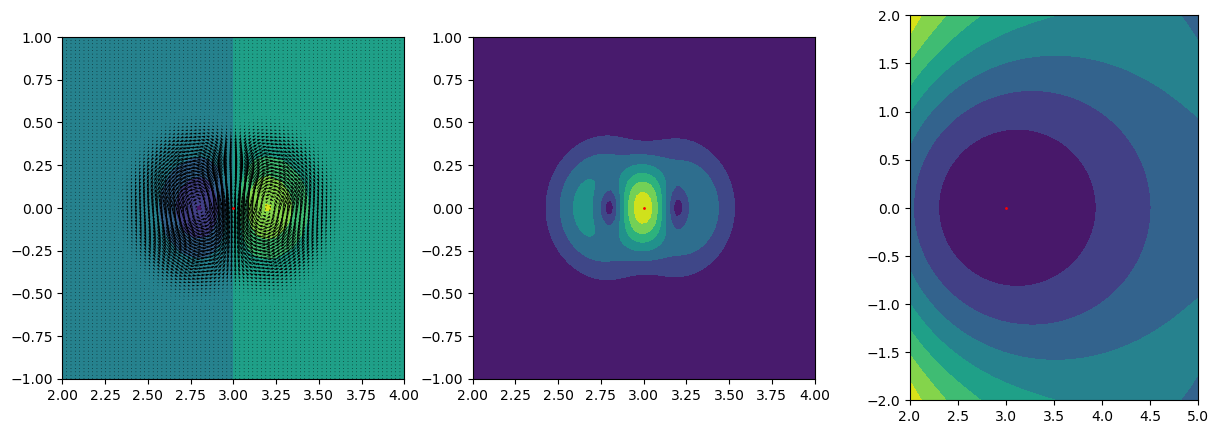

In [313]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

r = np.linspace(2, 5, 200)
z = np.linspace(-2, 2, 200)

R, Z = np.meshgrid(r, z)
Bs = np.array([ps.B([r, 0.0, z]) for r, z in zip(R.flatten(), Z.flatten())]).reshape(
    R.shape + (3,)
)
axs[2].contourf(R, Z, np.linalg.norm(Bs, axis=2))

r = np.linspace(2, 4, 80)
z = np.linspace(-1, 1, 100)

R, Z = np.meshgrid(r, z)
Bs = np.array([gaussian_perturbation([r, 0.0, z], ps._R0, ps._d, ps._m, ps._n) for r, z in zip(R.flatten(), Z.flatten())]).reshape(
    R.shape + (3,)
)
axs[1].contourf(R, Z, np.linalg.norm(Bs, axis=2))

psi = np.array([gaussian_psi([r, 0.0, z], ps._R0, ps._d, ps._m, ps._n) for r, z in zip(R.flatten(), Z.flatten())]).reshape(
    R.shape
)
psi = np.real(psi)
axs[0].contourf(R, Z, psi)
axs[0].quiver(R, Z, Bs[:, :, 0], Bs[:, :, 2])

# Set the aspect equal
for ax in axs:
    ax.set_aspect("equal")
    ax.scatter(ps._R0, 0, color="r", s=1)

# Add circle to the plot
# crop_circle(ps._R0, ps._d, ax, color='r')
# crop_circle(ps._R0, np.sqrt(2)*ps._d, ax, color='r')

In [315]:
# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-9

# set up the Poincare plot
pparams = dict()
pparams["Rbegin"] = 3 + 1e-3
pparams["Rend"] = 4
pparams["nPtrj"] = 10
pparams["nPpts"] = 1000
pparams["zeta"] = 0

pplot = PoincarePlot(ps, pparams, integrator_params=iparams)
pdata = pplot.compute()

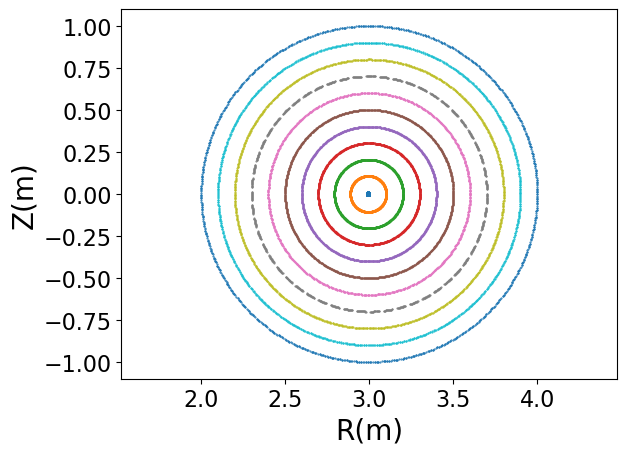

In [316]:
pplot.plot(marker=".", s=1)

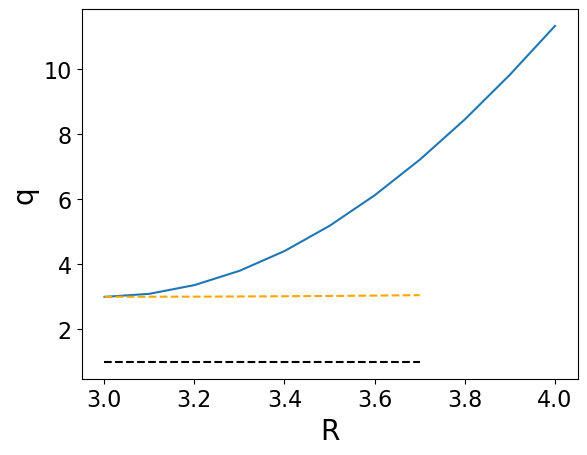

In [314]:
pplot.compute_iota()
pplot.plot_q()

plt.hlines(ps._n/ps._m, 3, 3.7, color="k", linestyle="--")

rho = np.linspace(3.001, 3.7, 20)
q=ps._sf+ps._shear*(ps._R0-rho)**2

plt.plot(rho, q, color="orange", linestyle="--")